# <center> **PROJECT-4. Задача классификации**

## <center> **`1.` Постановка задачи**

**Проблематика:** банки хранят огромные объёмы информации о своих клиентах. Эти данные можно использовать для того, чтобы оставаться на связи с клиентами и индивидуально ориентировать их на подходящие именно им продукты или банковские предложения. Обычно с выбранными клиентами связываются напрямую через разные каналы связи: лично (например, при визите в банк), по телефону, по электронной почте, в мессенджерах и так далее. Но проведение маркетинговых кампаний и взаимодействие с клиентами — это трудозатратно и дорого.

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

### <center> **ОРГАНИЗАЦИОННАЯ ИНФОРМАЦИЯ**

Проект будет состоять из шести частей:

`1.` **Постановка задачи**;

`2.` **Первичная обработка данных**;

`3.` **Разведывательный анализ данных (EDA)**;

`4.` **Отбор и преобразование признаков**;

`5.` **Решение задачи классификации: логистическая регрессия и решающие деревья**;

`6.` **Решение задачи классификации: ансамбли моделей и построение прогноза**.

## <center> **`2.` Знакомство с данными, обработка пропусков и выбросов**

**Импортируем библиотеки**

In [1]:
# Для работы с DataFrame
import pandas as pd
import numpy as np
from time import time
import warnings
warnings.filterwarnings('ignore')

# Для визуализации
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Для создания и обучения модели
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import optuna

**Загружаем данные**

In [2]:
# Загружаем датасет
bank_data = pd.read_csv('Прочие файлы/bank_fin.csv', sep=';')

# Создаём копию
bank_df = bank_data.copy()

In [ ]:
# Выводим первые пять строк
bank_df.head()

#### $Информация$ $о$ $датасете$

**Данные о клиентах банка:**

* `age` (возраст);
* `job` (сфера занятости);
* `marital` (семейное положение);
* `education` (уровень образования);
* `default` (имеется ли просроченный кредит);
* `housing` (имеется ли кредит на жильё);
* `loan` (имеется ли кредит на личные нужды);
* `balance` (баланс).


**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

* `contact` (тип контакта с клиентом);
* `month` (месяц, в котором был последний контакт);
* `day` (день, в который был последний контакт);
* `duration` (продолжительность контакта в секундах).


**Прочие признаки:**

* `campaign` (количество контактов с этим клиентом в течение текущей кампании);
* `pdays` (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* `previous` (количество контактов до текущей кампании)
* `poutcome` (результат прошлой маркетинговой кампании).

**Целевой признак:**

* `deposit` (согласится ли клиент открыть депозит в банке)

#### $2.1$ 
Выводим информацию о пропусках

In [4]:
bank_df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Построем тепловую карту пропусков

balance    0.223974
dtype: float64


<AxesSubplot:>

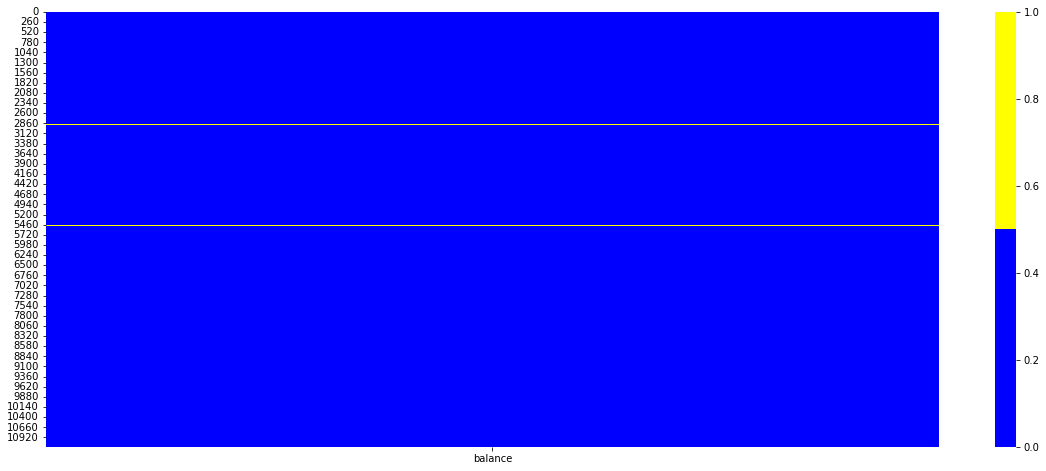

In [3]:
def missing_values_heatmap(data):
    
    # Рассчитываем количество пропусков
    cols_null_persent = data.isnull().mean() * 100
    cols_with_null = cols_null_persent[cols_null_persent > 0].sort_values(ascending = False)
    print(cols_with_null)
    
    # Задаём параметры графика
    colors = ['blue', 'yellow']
    fig = plt.figure(figsize = (20, 8))
    cols = cols_with_null.index
    
    # Строим тепловую карту
    ax = sns.heatmap(
        data = data[cols].isnull(),
        cmap = sns.color_palette(colors)
    )
    
    return ax

missing_values_heatmap(bank_df)

**Вывод:** 

Из полученных результатов видно, что в данных присутствует 25 пропусков в признаке `balance`

#### $2.2$
Обрабатываем пропуски

**Обрабатываем пропущенные значения в признаке 'balance'**

In [4]:
# Создаём функицию для преобразования значений из dtype 'str' в 'float'
def get_numbers(number):
    number = str(number)
    
    # Создаём внутреннюю функцию для удаления символа '$' и лишних пробелов
    def delete_symbols(num):
        
        # Удаляем символ и пробелы
        if len(num) > 5:
            num = num[:-6]
        else:
            num = num[:-4]
        return num.replace(' ', '')
    
    
    # Преобразовываем очищенные значения в dtype 'float'
    if (delete_symbols(number) != 'nan') and (delete_symbols(number) != ''):
        return float(delete_symbols(number))
    


# Применяем полученную функцию к признаку 'balance'    
bank_df['balance'] = bank_df['balance'].apply(get_numbers)

# Выводим среднее значение признака округлив до 3-го знака после запятой
print(round(bank_df['balance'].mean(), 3))

1529.129


In [5]:
# Заполняем пропуски медианным значением
bank_df['balance'].fillna(bank_df['balance'].median(), inplace=True)

# Выводим среднее значение признака округлив до 3-го знака после запятой
print(round(bank_df['balance'].mean(), 3))

1526.936


**Обрабатываем пропущенные значения в признаке 'job'**

In [6]:
# Выведем информацию о признаке 'job'
bank_df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Среди имеющихся значений имеются неизвестные (unknown). Сперва удалим эти значения (создадим видимые пропуски), а потом заполним их модой.

In [7]:
# Создаём функцию для удаления значений 'unknown'
def delete_unknown(row):
    
    if row == 'unknown':
        row = None
    return row


# Применяем полученную функцию к признаку 'job'
bank_df['job'] = bank_df['job'].apply(delete_unknown)

# Заполняем пропуски модальным значением
bank_df['job'].fillna(bank_df['job'].mode()[0], inplace=True)

**Обрабатываем пропущенные значения в признаке 'education'**

In [8]:
# Выведем информацию о признаке 'education'
bank_df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [9]:
# Применяем функцию delete_unknown() к признаку 'education'
bank_df['education'] = bank_df['education'].apply(delete_unknown)

# Заполняем пропуски модальным значением
bank_df['education'].fillna(bank_df['education'].mode()[0], inplace=True)

Выведем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования, округлив до 3-х знаков после точки-разделителя.

In [10]:
# Отфильтруем датасет по признакам 'education' и 'job' и занесём в отдельную переменную
popular_job_and_education = bank_df[(bank_df.education == 'secondary') & (bank_df.job == 'management')]

# Выводим среднее значение признака округлив до 3-го знака после запятой
print(round(popular_job_and_education['balance'].mean(), 3))

1598.883


#### $2.3$
Обрабатываем выбросы

Построим гистограмму и коробчатую диаграмму для признака баланса клиентов (`balance`):

Text(0.5, 1.0, 'Client Balance Boxplot')

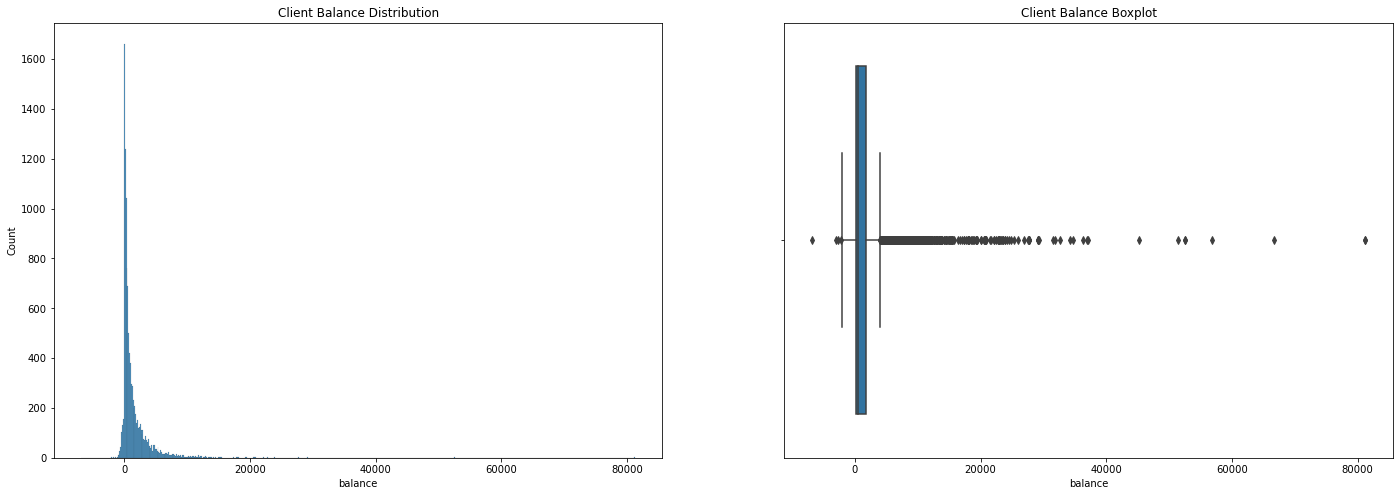

In [11]:
# Задаём параметры 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

# Строим гистограмму
histplot = sns.histplot(
    data = bank_df,
    x = 'balance',
    ax = axes[0]
);

# Название гистограммы
histplot.set_title('Client Balance Distribution');

# Строим коробчатую диаграмму
boxplot = sns.boxplot(
    data = bank_df,
    x = 'balance',
    ax = axes[1]
);

# Название коробчатой диаграммы
boxplot.set_title('Client Balance Boxplot')

Вычислим верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.

In [12]:
# Выделяем признак 'balance'
x = bank_df['balance']

# Вычисляем 25-ый и 75-ый квантили (первый и третий квартили)
quartile_1, quartile_3 = np.percentile(x, 25), np.percentile(x, 75)

# Вычисляем межквартильное расстояние
iqr = quartile_3 - quartile_1

# Вычисляем нижнюю границу
lower_bound = quartile_1 - (iqr * 1.5)

# Вычисляем верхнюю границу
upper_bound = quartile_3 + (iqr * 1.5)

# Выводим верхнюю границу
print(f'Верхняя граница поиска: {round(upper_bound)}')

# Выводим нижнюю границу
print(f'Нижняя граница поиска: {round(lower_bound)}')

Верхняя граница поиска: 4063
Нижняя граница поиска: -2241


In [13]:
# Рассчитаенм количество выбросов
outliers = bank_df[(x < lower_bound) | (x > upper_bound)]

# Удаляем выбросы
bank_df = bank_df[(x >= lower_bound) & (x <= upper_bound)]

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {bank_df.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


**Вывод:** 

Используя метод Тьюки было выявлено 1057 выбросов из 10105 записей

Согласно классическому методу Тьюки, под выбросы у нас попали 1057 записей в таблице. Построим гистограмму и коробчатую диаграмму на очищенных данных bank_df:

Text(0.5, 1.0, 'Cleaned Client Balance Boxplot')

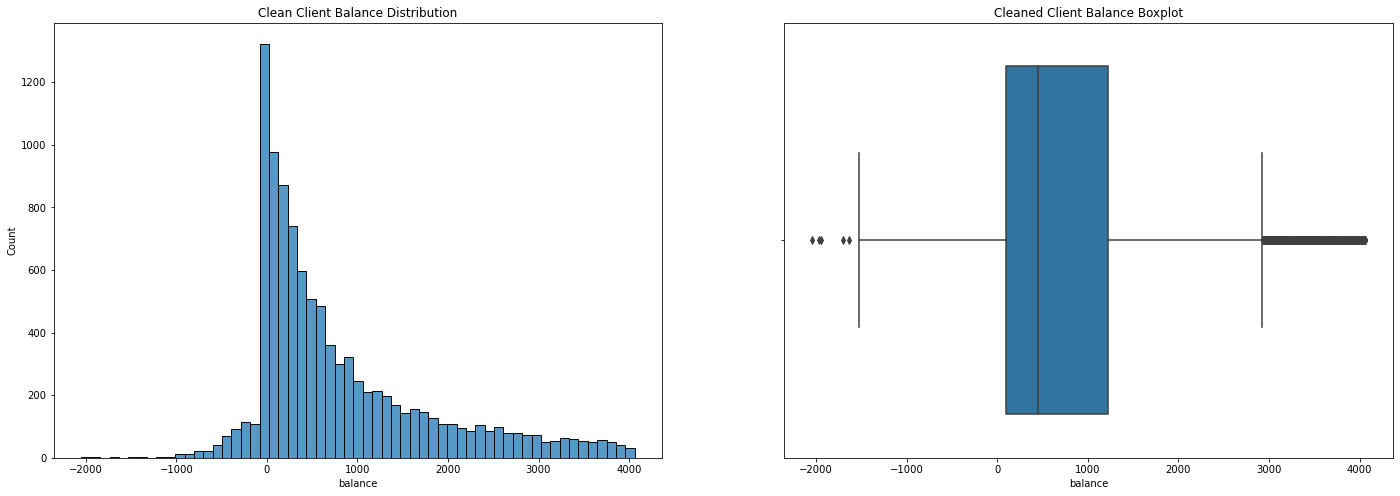

In [14]:
# Задаём параметры графика
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))


# Строим гистограмму
histplot = sns.histplot(
    data = bank_df,
    x = 'balance',
    ax = axes[0]
);

# Название графика
histplot.set_title('Clean Client Balance Distribution');



# Строим коробчатую диаграмму
boxplot = sns.boxplot(
    data = bank_df,
    x = 'balance',
    ax = axes[1]
);

# Название графика
boxplot.set_title('Cleaned Client Balance Boxplot')

## <center> **`3.` Разведывательный анализ данных**

#### $3.1$ 
Посмотрим на количество клиентов, открывших счёт в банке, и на количество, которые не открыли.

In [15]:
# Выведем количество открытых счетов в банке и неотнрытых
bank_df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

Построим диаграмму распределения счёта клиентов банка

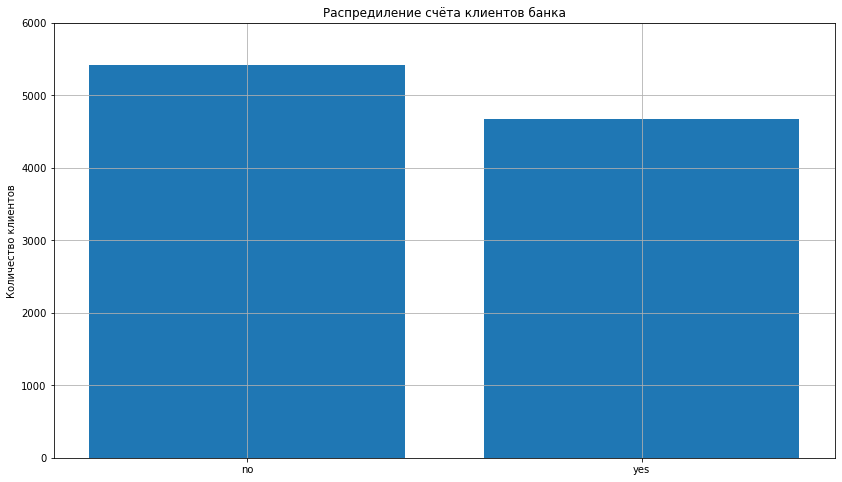

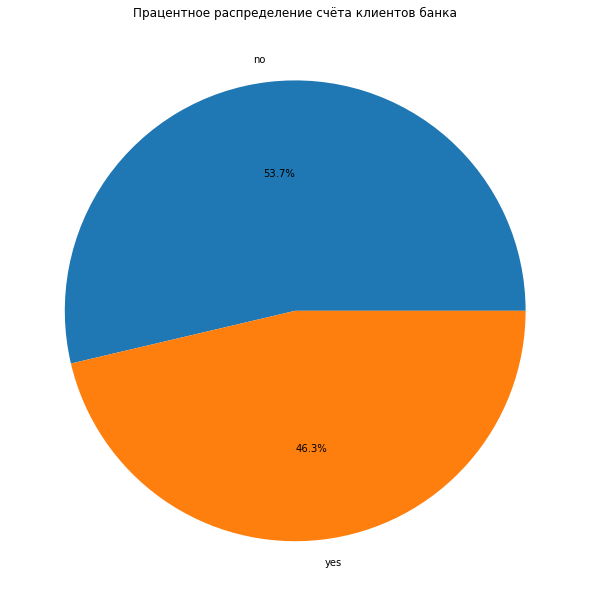

In [16]:
deposit_distribution = bank_df['deposit'].value_counts()


# Строим столбчатую диаграмму
fig, ax = plt.subplots(figsize = (14, 8))

ax.bar(
    x = deposit_distribution.index,
    height = deposit_distribution
)

ax.set_ylabel('Количество клиентов')
ax.set_title('Распредиление счёта клиентов банка')

plt.ylim(0, 6000)
plt.grid()
plt.show();



# Строик круговую диаграмму
fig = plt.figure(figsize = (8, 8))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    deposit_distribution,
    labels = deposit_distribution.index,
    autopct = '%.1f%%'
)

axes.set_title('Працентное распределение счёта клиентов банка');

**Вывод:** 

Из полученной диаграммы можно заключить, что среди всех клиентов банка открывают депозит только 46.3%, т.е. меньше половины от общего числа

In [17]:
print('Максимальный возраст клиента банка: {}'.format(bank_df['age'].max()), '\n')
print('Минимальная продолжительность разговора с клиентом банка: {}'.format(bank_df['duration'].min()), '\n')
print('Количество месяцев, в которых проводилась маркетинговая кампания: {}'.format(bank_df['month'].nunique()), '\n')
print('Количество сфер занятости среди клиентов банка: {}'.format(bank_df['job'].nunique()))

Максимальный возраст клиента банка: 95 

Минимальная продолжительность разговора с клиентом банка: 2 

Количество месяцев, в которых проводилась маркетинговая кампания: 12 

Количество сфер занятости среди клиентов банка: 11


#### $3.2$ 
Выведем значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач

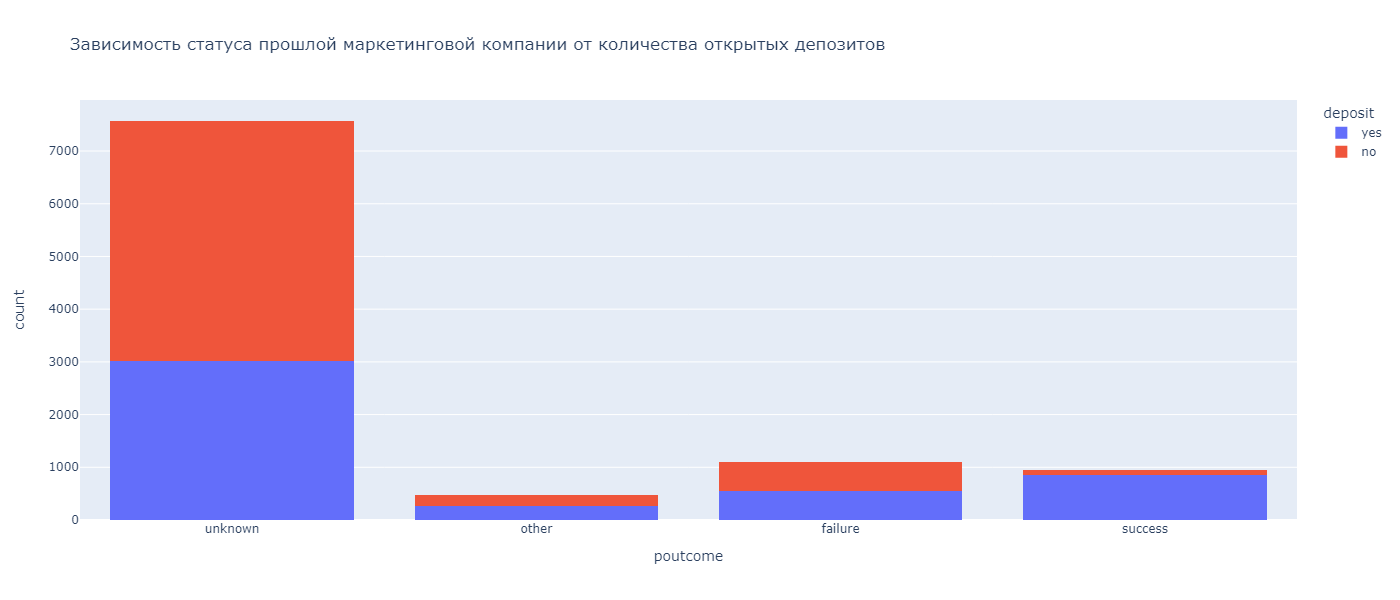

In [18]:
# Строим гистаграмму
fig = px.histogram(
    data_frame = bank_df, # DataFrame
    x = 'poutcome',       # распределение по оси x
    color = 'deposit',    # цвет столбцов
    barmode = 'stack',    # тип графика
    title = 'Зависимость статуса прошлой маркетинговой компании от количества открытых депозитов'
)

# Задаём размер графика
fig.update_layout(height = 600, width = 1400) 

# Выводим график
fig.show('png')

**Вывод:** 

По построенной диаграмме видно, что статус предыдущей кампании, для которой в текущей успехов намного больше, чем неудач, является **success**.

#### $3.3$ 
Выведем месяц, в котором наблюдался самый большой процент неудач при взаимодействии в текущей маркетинговой кампании

In [19]:
failure_mounths = bank_df[bank_df['poutcome'] == 'failure']
failure_mounths['month'].value_counts(normalize = True)

may    0.302074
apr    0.135257
nov    0.125338
feb    0.114518
aug    0.075744
oct    0.055906
jun    0.043282
sep    0.041479
jul    0.037872
jan    0.035167
mar    0.023445
dec    0.009919
Name: month, dtype: float64

#### $3.4$ 
Выведем возрастные категории, в каких люди чаще открывают депозиты, а в каких — реже.

In [20]:
# Создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
bank_df['age_group'] = pd.cut(bank_df['age'], bins=[0, 29, 40, 50, 60, 120], labels=['<30', '30-40', '40-50', '50-60', '60+'])

deposit_yes = bank_df[bank_df['deposit'] == 'yes']
deposit_yes['age_group'].value_counts()

30-40    1817
40-50     895
<30       861
50-60     692
60+       416
Name: age_group, dtype: int64

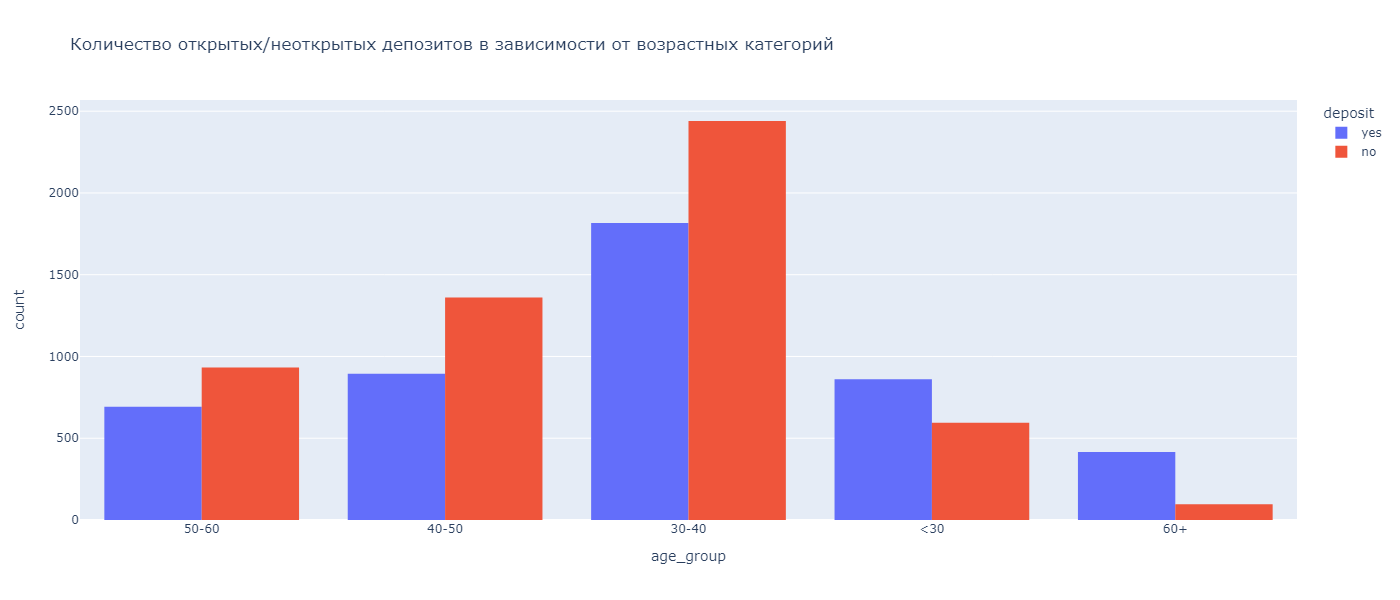

In [21]:
# Строим диаграмму
fig = px.histogram(
    data_frame = bank_df,      # DataFrame 
    x = 'age_group',           # распределение по оси x
    color = 'deposit',         # цвет столбцов
    barmode = 'group',         # тип графика
    height = 600,              # высота
    width = 1400,              # ширина
    title = 'Количество открытых/неоткрытых депозитов в зависимости от возрастных категорий'
)

# Выводим график
fig.show('png')

**Вывод:** 

Из полученной диаграммы видно, что возрастной диапазон клиентов, которые склонны чаще открывать счёт в банке, находится в пределах до 30-ти и от 60-ти лет. Причём возраст клиентов, которые чаще других открывают счёт, находится в диапазоне от 30 до 40 лет, но и количество отказов от депозита в этой возрастной категории самое большое.

#### $3.5$ 
Выведем соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

* семейное положение;
* уровень образования;
* сфера занятости.

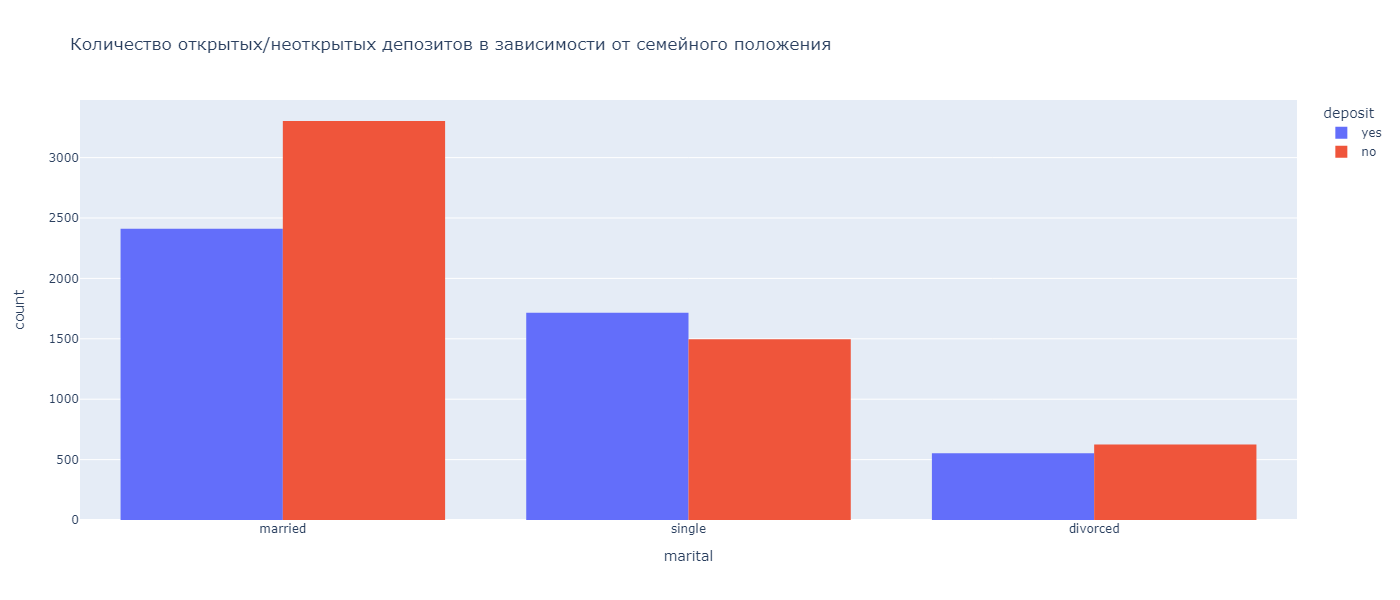

In [24]:
# Строим диаграмму
fig = px.histogram(
    data_frame = bank_df,   # DataFrame
    x = 'marital',          # распределение по оси x
    color = 'deposit',      # цвет столбцов
    barmode = 'group',      # тип графика
    height = 600,           # высота
    width = 1400,           # ширина
    title = 'Количество открытых/неоткрытых депозитов в зависимости от семейного положения'
)

# Выводим график
fig.show('png')

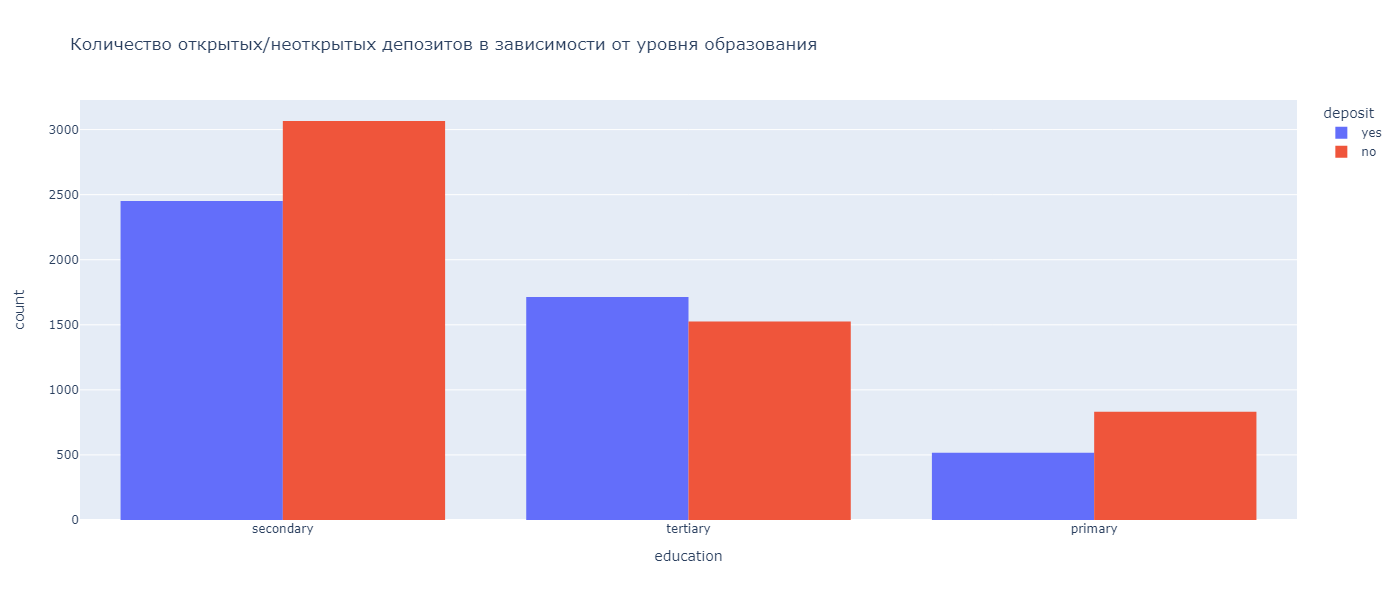

In [25]:
# Строим диаграмму
fig = px.histogram(
    data_frame = bank_df,      # DataFrame 
    x = 'education',           # распределение по оси x
    color = 'deposit',         # цвет столбцов
    barmode = 'group',         # тип графика
    height = 600,              # высота
    width = 1400,              # ширина
    title = 'Количество открытых/неоткрытых депозитов в зависимости от уровня образования'
)

# Выводим график
fig.show('png')

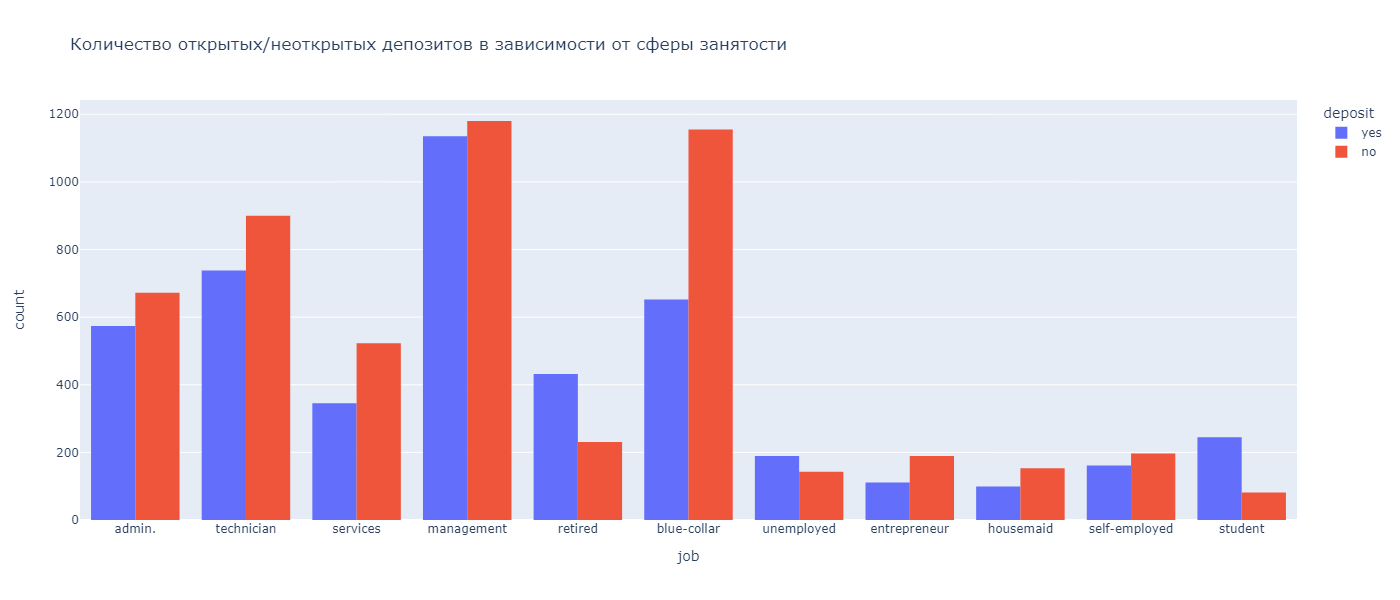

In [26]:
# Строим диаграмму
fig = px.histogram(
    data_frame = bank_df,      # DataFrame 
    x = 'job',                 # распределение по оси x
    color = 'deposit',         # цвет столбцов
    barmode = 'group',         # тип графика
    height = 600,              # высота
    width = 1400,              # ширина
    title = 'Количество открытых/неоткрытых депозитов в зависимости от сферы занятости'
)

# Выводим график
fig.show('png')

**Вывод:** 

Полученные диаграммы показывают, что к категорям клиентов, которые чаще открывают счёт, относятся люди, не состоящие в браке (в том числе в прошлом), имеющие высшее образование либо в процессе получения, а так же люди, ушедшие на пенсию, либо безработные.

#### $3.6$ 
Разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части построим сводную диаграмму по уровню образования и семейному положению. Результаты отобразим в виде тепловых карт.

Выделяем часть для тех клиентов, которые открыли депозит

marital    divorced  married  single
education                           
primary          96      339      82
secondary       283     1289     879
tertiary        174      784     755


Text(0.5, 1.0, 'Тепловая карта категории людей, открывших депозит')

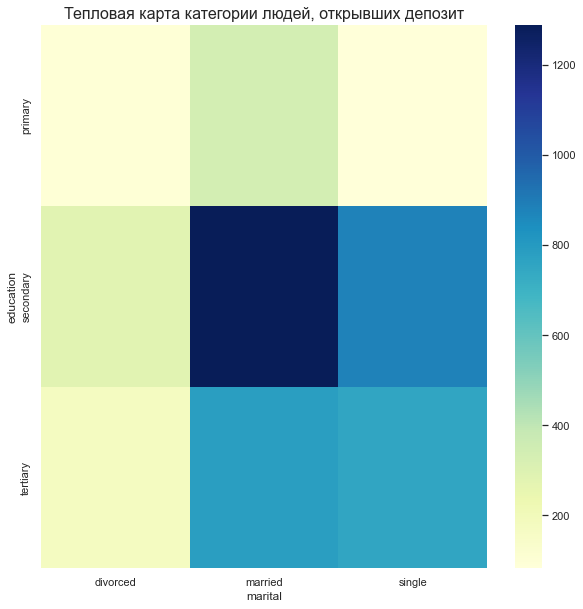

In [25]:
deposit_yes = bank_df[bank_df.deposit == 'yes']

category_deposit_yes = pd.crosstab(deposit_yes.education, deposit_yes.marital)
print(category_deposit_yes)

# Строим тепловую карту
sns.set (rc = {'figure.figsize': (10, 10)})

heatmap = sns.heatmap(
    data = category_deposit_yes,
    cmap = 'YlGnBu'
)

heatmap.set_title('Тепловая карта категории людей, открывших депозит', fontsize = 16)

Выделяем часть для тех клиентов, которые не открыли депозит

marital    divorced  married  single
education                           
primary          91      641     100
secondary       370     1830     866
tertiary        163      832     531


Text(0.5, 1.0, 'Тепловая карта категории людей, не открывших депозит')

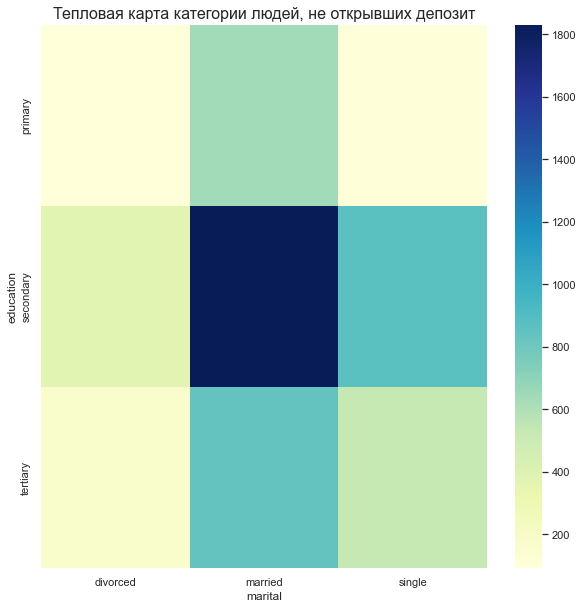

In [26]:
deposit_no = bank_df[bank_df.deposit == 'no']

category_deposit_no = pd.crosstab(deposit_no.education, deposit_no.marital)
print(category_deposit_no)

# Строим тепловую карту
sns.set (rc = {'figure.figsize': (10, 10)})

heatmap = sns.heatmap(
    data = category_deposit_no,
    cmap = 'YlGnBu'
)

heatmap.set_title('Тепловая карта категории людей, не открывших депозит', fontsize = 16)

**Вывод:**

К клиентам, которые чаще других соглашаются открыть счёт, относятся люди, в данный момент состоящие в браке, имеющие среднее образование и работающие на позициях менеджмента.

Выведем соотношение успешных и неуспешных контактов с клиентами по месяцам

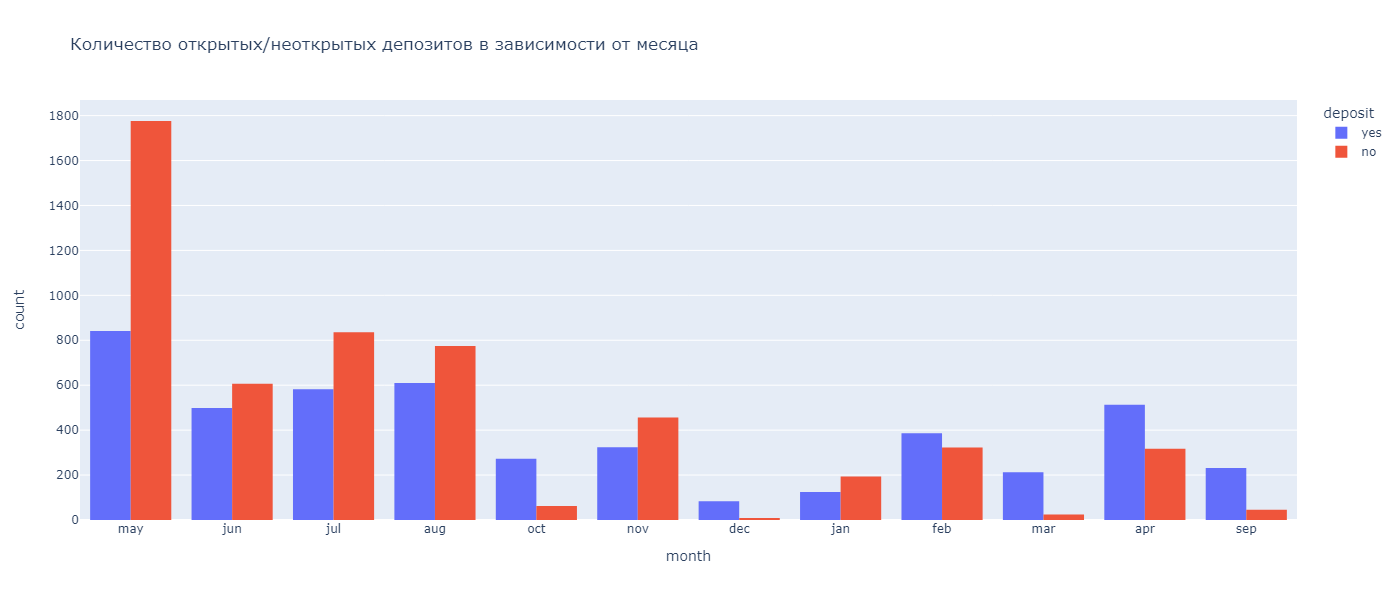

In [29]:
# Строим диаграмму
fig = px.histogram(
    data_frame = bank_df,      # DataFrame 
    x = 'month',               # распределение по оси x
    color = 'deposit',         # цвет столбцов
    barmode = 'group',         # тип графика
    height = 600,              # высота
    width = 1400,              # ширина
    title = 'Количество открытых/неоткрытых депозитов в зависимости от месяца'
)

# Выводим график
fig.show('png')

**Вывод:** 

По построенной диаграмме распределения депозита по месяцам мы видим, что клиенты чаще открывают счёт в апреле, декабре, феврале, марте, октябре и сентябре. Пик открытых депозитов приходится на май.

## <center> **`4.` Отбор и преобразование признаков**

#### $4.1$ 
Обработаем признак `education` с помощью метода **LabelEncoder()**

In [27]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Обрабатываем признак 'education'   
bank_df['education'] = lab_enc.fit_transform(bank_df['education'])

# Выведем сумму получившихся значений для признака education
bank_df['education'].sum()

11995

Обработаем признак `age_group` с помощью метода **LabelEncoder()**

In [28]:
# Обрабатываем признак 'age_group'   
bank_df['age_group'] = lab_enc.fit_transform(bank_df['age_group'])

Перекодируем переменную `deposit`

In [29]:
# Создаём lambda-функцию для замены строк на числа
row_bin = lambda row: 1 if row == 'yes' else 0

# Применяем полученную функцию к признаку 'deposit'
bank_df['deposit'] = bank_df['deposit'].apply(row_bin)

#### $4.2$ 
Вычислим стандартное отклонение по преобразованной в корректный вид целевой переменной `deposit`. Ответ округлим до трёх знаков после точки-разделителя.

In [30]:
# Рассчитываем стандартное отклонение
print(round(bank_df['deposit'].std(), 3))

0.499


Перекадируем переменные `default`, `housing` и `loan`

In [31]:
# Применим lambda-функцию row_bin для замены строк на числа в перечисленных признаках
bank_df['default'] = bank_df['default'].apply(row_bin)
bank_df['housing'] = bank_df['housing'].apply(row_bin)
bank_df['loan'] = bank_df['loan'].apply(row_bin)

#### $4.3$ 
Вычислим среднее арифметическое для каждой из получившихся переменных, сложим три результата и выведем значение, округлив его до трёх знаков после точки-разделителя.

In [32]:
# Рассчитываем среднее арифметическое признака 'default'
default_average = bank_df['default'].sum() / len(bank_df['default'])

# Рассчитываем среднее арифметическое признака 'housing'
housing_average = bank_df['housing'].sum() / len(bank_df['housing'])

# Рассчитываем среднее арифметическое признака 'loan'
loan_average = bank_df['loan'].sum() / len(bank_df['loan'])

print(round((default_average + housing_average + loan_average), 3))

0.635


Перекадируем переменные `job`, `marital`, `contact`, `month` и `poutcome`

In [33]:
bank_df = pd.get_dummies(bank_df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=True)

### Строим матрицу корреляций

Построим тепловую карту корреляций признаков.

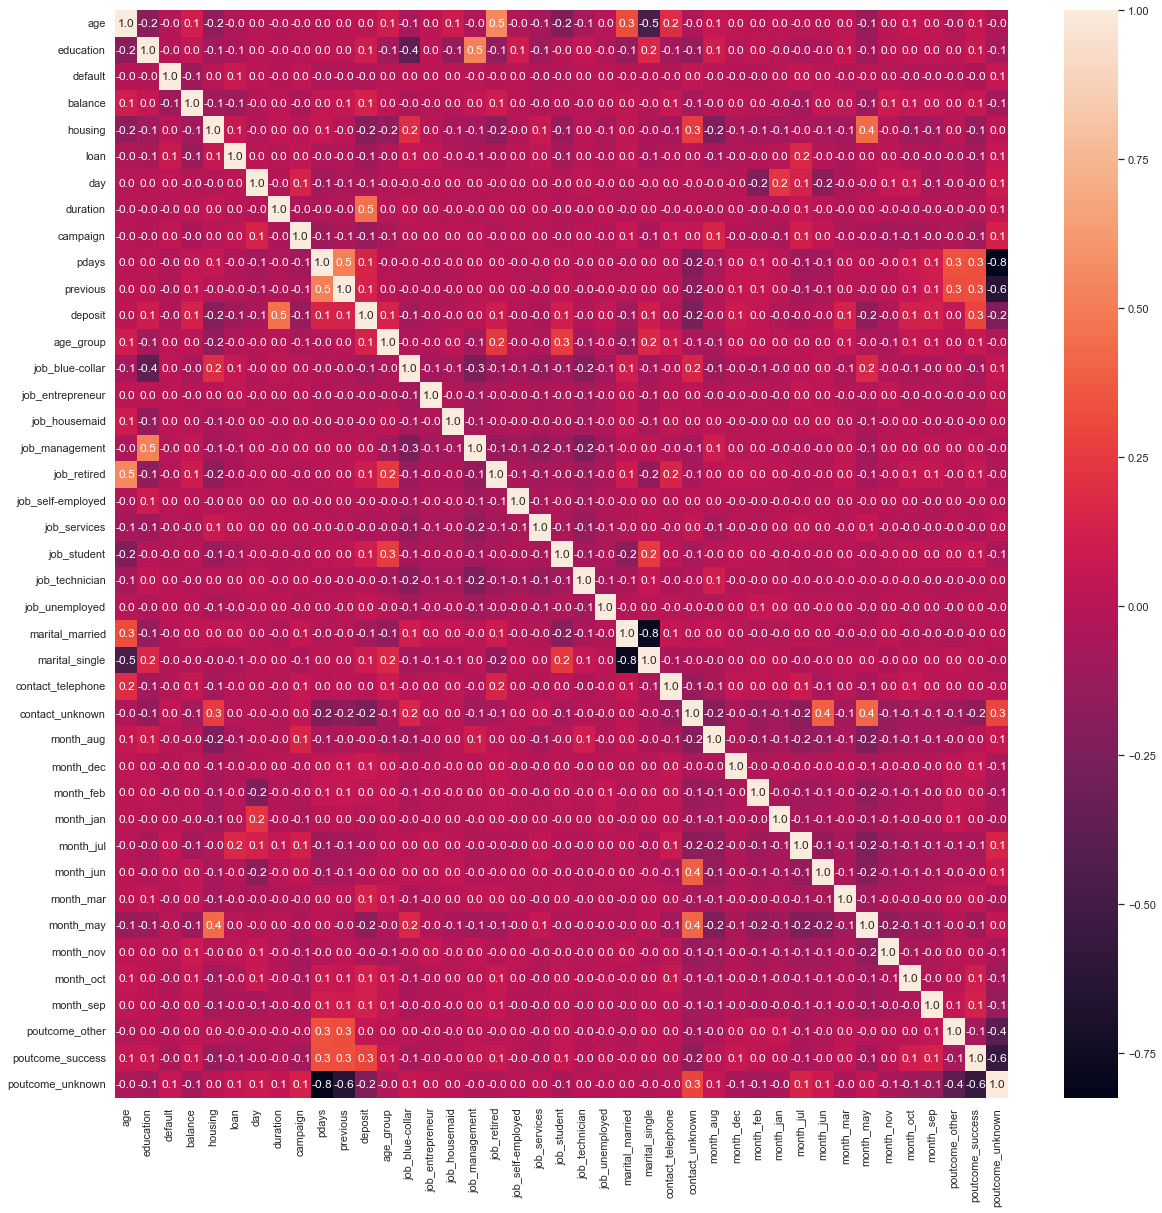

In [34]:
plt.rcParams['figure.figsize'] = (20, 20)
sns.heatmap(bank_df.corr(), annot=True, fmt='.1f');

Построим столбчатую диаграмму для ранжированных коэффициентов корреляции

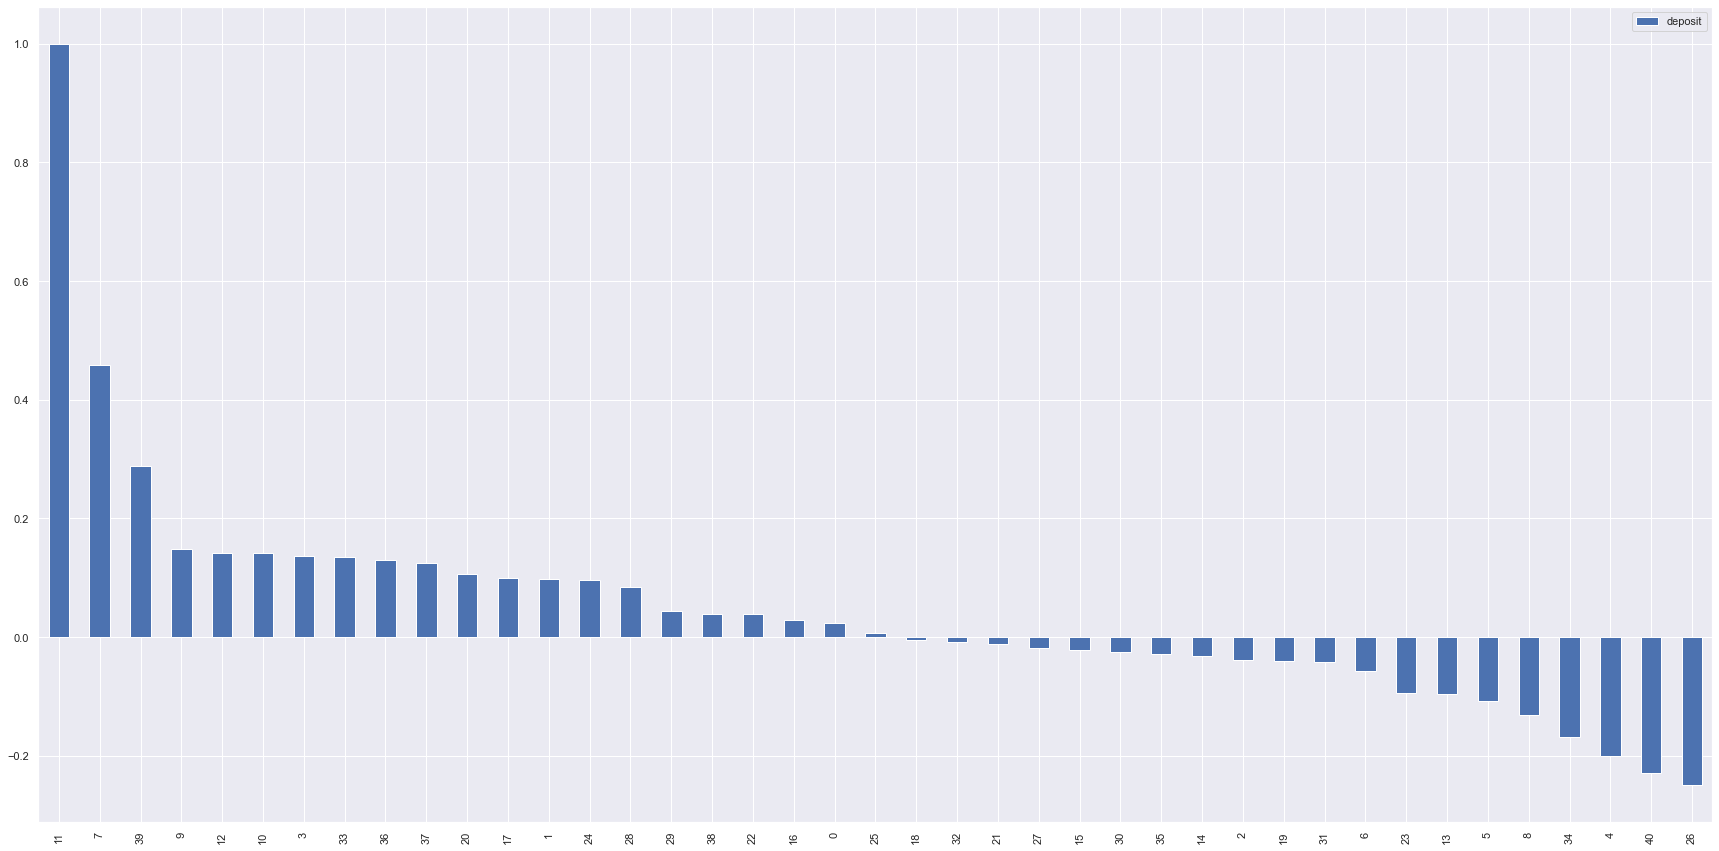

In [35]:
# Задаём параметры
bank_corr = bank_df.corr()
bank_corr = bank_corr['deposit'].reset_index()
bank_corr = bank_corr.sort_values('deposit', ascending = False)

# Строим диаграмму
bank_corr.plot(
    kind = 'bar',
    grid = True,
    figsize = (30, 15)
);

#### $4.4$ 
Определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую.

In [36]:
# Составляем список факторов (исключили целевой столбец)
features = bank_df.drop('deposit', axis=1).columns

# Составляем матрицу наблюдений X и вектор правильных ответов y
X = bank_df[features]
y = bank_df['deposit']

Разделяем выборку на обучающую и тестовую

In [37]:
# Разделим данные с помощью sklearn на данные для обучения и теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Выведем среднее значение целевой переменной на тестовой выборке. Ответ округлим до двух знаков после точки-разделителя.

In [38]:
print(round(y_test.mean(), 2))

0.47


#### $4.5$ 
С помощью **SelectKBest()** отберём 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуем по обучающей выборке, используя параметр $score$ $func$ = `f_classif`.

In [39]:
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'job_retired', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

Удаляем ненужные признаки

In [40]:
bank_df = bank_df.drop([
    'age',
    'education',
    'default',  
    'loan',  
    'day',   
    'job_blue-collar',  
    'job_entrepreneur',  
    'job_housemaid',  
    'job_management',  
    'job_self-employed',  
    'job_services',  
    'job_student',  
    'job_technician',  
    'job_unemployed',  
    'marital_married',  
    'marital_single',  
    'contact_telephone',  
    'month_aug',  
    'month_dec',  
    'month_feb',  
    'month_jan',  
    'month_jul',  
    'month_jun',  
    'month_nov',  
    'poutcome_other'  
], axis=1)

In [41]:
bank_df.head()

,balance,housing,duration,campaign,pdays,previous,deposit,age_group,job_retired,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
0,2343.0,1,1042,1,-1,0,1,2,0,1,0,1,0,0,0,1
1,45.0,0,1467,1,-1,0,1,2,0,1,0,1,0,0,0,1
2,1270.0,1,1389,1,-1,0,1,1,0,1,0,1,0,0,0,1
3,2476.0,1,579,1,-1,0,1,2,0,1,0,1,0,0,0,1
4,184.0,0,673,2,-1,0,1,2,0,1,0,1,0,0,0,1


#### $4.6$ 
Нормализуем данные используя *min-max*-нормализацию.

In [ ]:
# Задаём параметры графика
fig, (ax) = plt.subplots(ncols = 1, figsize = (20, 10))

# Название графика
ax.set_title('Исходные распределения')

# Строим график
for column in hotels_df.columns:
    sns.kdeplot(hotels_df[column], ax=ax, label=column)
    

# Выводим график
plt.legend()

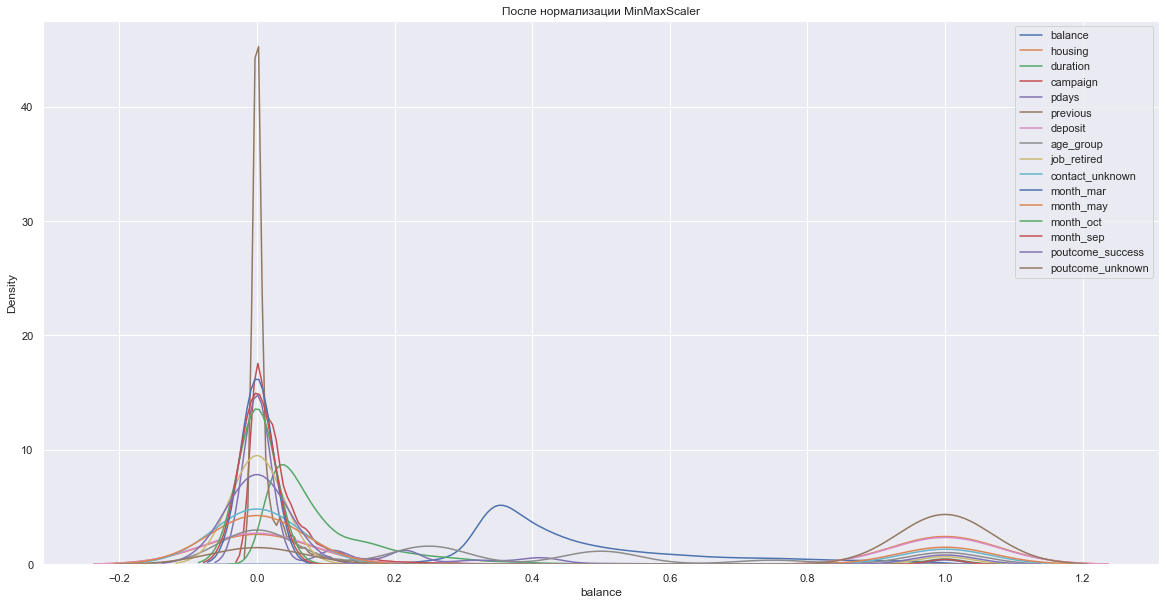

In [42]:
# Инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# Кодируем исходный датасет
bank_df_mm = mm_scaler.fit_transform(bank_df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
bank_df_mm = pd.DataFrame(bank_df_mm, columns=list(bank_df.columns))

# Визуализируем данные
fig, (ax) = plt.subplots(ncols=1, figsize=(20, 10))
ax.set_title('После нормализации MinMaxScaler')

# Строим график
for column in bank_df_mm.columns:
    sns.kdeplot(bank_df_mm[column], ax=ax, label=column)

# Выводим график
plt.legend()

Разделим данные обновлённого датасета

In [43]:
# Составляем список факторов (исключили целевой столбец)
features = bank_df_mm.drop('deposit', axis=1).columns

# Составляем матрицу наблюдений X и вектор правильных ответов y
X = bank_df_mm[features]
y = bank_df_mm['deposit']

# Разделим данные с помощью sklearn на данные для обучения и теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Рассчитаем среднее арифметическое для первого предиктора из тестовой выборки. Ответ округлите до двух знаков после точки-разделителя.

In [44]:
print(round(X_test['balance'].mean(), 2))

0.47


## <center> **`5.` Решение задачи классификации: логистическая регрессия и решающие деревья**

#### $5.1$ 
Обучим модель логистической регрессии

In [44]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter=1000, solver='sag', random_state=42)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

# Делаем предсказание
y_pred_log = log_reg.predict(X_test)

# Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred_log))

# Оцениваем качество модели на тестовой выборке
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_log)))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84      1760
         1.0       0.85      0.76      0.80      1575

    accuracy                           0.82      3335
   macro avg       0.83      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335

accuracy на тестовом наборе: 0.82


#### $5.2$ 
Обучим модель решающие деревья

In [45]:
# Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion = 'entropy', # критерий информативности
    max_depth = 6,         # максимальная глубина дерева
    random_state = 42      # генератор случайных чисел
)

# Обучаем модель по алгоритму CART
dt_clf.fit(X_train, y_train)

# Делаем предсказание класса
y_pred_dtc = dt_clf.predict(X_test)

# Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83      1760
         1.0       0.82      0.78      0.80      1575

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



#### $5.3$ 
Переберём комбинаций различных параметров и выберем тот вариант, при котором модель будет давать наиболее точный прогноз

Оптимизируем гиперпараметры при поиощи **GridSearchCV()**

In [46]:
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

grid_search_tree = GridSearchCV(
    
    estimator = tree.DecisionTreeClassifier(
        criterion = 'entropy',
        max_depth = 6,
        random_state = 42
    ),
    
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1
)

%time grid_search_tree.fit(X_train, y_train)
y_train_pred = grid_search_tree.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search_tree.score(X_test, y_test)))

y_test_pred = grid_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_tree.best_params_))

Wall time: 3.25 s
f1_score на обучающем наборе: 0.82
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


**Вывод:** 

По полученным результатам можно заключить, что наилучшее значение метрики удалось получить при использовании логистической регрессии

## <center> **`6.` Решение задачи классификации: ансамбли моделей и построение прогноза**

#### $6.1$ 
Обучим модель случайный лес

In [47]:
# Создаём объект класса RandomForestClassifier
rf_clf = ensemble.RandomForestClassifier(
    n_estimators = 100,   # количество деревьев в ансамбле
    criterion = 'gini',   # критерий информативности
    min_samples_leaf = 5, # минимальное количество листьев
    max_depth = 10,       # максимальная глубина дерева
    random_state = 42     # генератор случайных чисел
)

# Обучаем модель на тренировочной выборке
rf_clf.fit(X_train, y_train)

# Делаем предсказание класса на тестовой выборке
y_pred_forest = rf_clf.predict(X_test)

# Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83      1760
         1.0       0.81      0.84      0.82      1575

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



#### $6.2$ 
Обучим модель градиентного бустинга (**GradientBoostingClassifier()**)

In [48]:
# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    learning_rate = 0.05, # темп обучения
    n_estimators = 300,   # количество деревьев в ансамбле
    min_samples_leaf = 5, # минимальное количество листьев
    max_depth = 5,        # максимальная глубина дерева
    random_state = 42     # генератор случайных чисел
)

# Обучаем модель на тренировочной выборке
gb.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
gb_pred = gb.predict(X_test)

# Выводим отчёт о метриках
print(metrics.classification_report(y_test, gb_pred))

# Оцениваем качество по метрике F1 на тестовом наборе
print('f1_score на тестовом наборе данных: {:.2f}'.format(metrics.f1_score(y_test, gb_pred)))

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      1760
         1.0       0.81      0.84      0.83      1575

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

f1_score на тестовом наборе данных: 0.83


#### $6.3$ 
Построим ансамбль из следующих моделей: `решающие деревья`, `логистическая регрессия` и `градиентный бустинг`. В качестве метамодели используем модель логистической регрессии.

Воспользуемся **стекингом**

In [49]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', linear_model.LogisticRegression(max_iter=1000, solver='sag', random_state=42)),
    ('dt_clf', tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)),
    ('gb', GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42))
]


# Создаем объект класса стекинг
reg = StackingClassifier(
    
    # Базовые модели в стекинге
    estimators = estimators,
    
    # Метамодель
    final_estimator = linear_model.LogisticRegression()
    
)

# Обучаем модель на тренировочной выборке
reg.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test)

# Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85      1760
         1.0       0.82      0.84      0.83      1575

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



Отобразим наиболее значимые признаки

In [58]:
# Выведем 3 наиболее значимых признаков обновлённого датасета
selector = SelectKBest(score_func=f_classif, k=3)
selector.fit(X_train, y_train)

selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

#### $6.4$ 
Оптимизируем гиперпараметры при поиощи **Optuna**

In [50]:
# Фиксируем значение random_state
random_state = 42

def optuna_rf(trial):
    
    # Задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Cоздаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state = random_state
    )
    
    # Oбучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    
    return score


# Cоздаем объект исследования
study = optuna.create_study(study_name = 'RandomForestClassifier', direction = 'maximize')

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials = 20)

# Выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров: {}'.format(study.best_params))
print('f1_score на обучающем наборе: {:.2f}'.format(study.best_value))

Наилучшие значения гиперпараметров: {'n_estimators': 187, 'max_depth': 27, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [51]:
# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state = random_state)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('accuracy на тестовом наборе: {:.2f}'.format(model.score(X_test, y_test)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


## <center> **Вывод**

По окончании обработки данных, построения и тестирования различных моделей наилучший результат показали ансамблиевая модель логистической регрессии (значение метрики **f1_score** на обучающем и тестовом наборе равны: `0.85` и `0.83` соответственно). 